# Model Explainability Using Grad-CAM

## Notebook Overview
This notebook focuses on **model explainability** for the multimodal property valuation system. Grad-CAM is used to visualize which regions of satellite images influenced the model’s price predictions.

## Explainability Setup
To analyze visual attention patterns, properties were divided into two groups:
- Top 10% highest-priced houses
- Bottom 10% lowest-priced houses

Representative samples from both groups were selected, and Grad-CAM heatmaps were generated using the CNN-based image feature extractor.

## Grad-CAM Visualization
Grad-CAM highlights important image regions using color intensity:
- Warmer colors (red/yellow) indicate regions that contributed more strongly to the model’s prediction
- Cooler colors (blue) indicate lower influence regions

These visualizations help interpret how environmental and neighborhood features captured in satellite imagery affect predicted property values.

## Key Insight
The Grad-CAM results provide qualitative evidence that the model attends to different spatial patterns for high-value and low-value properties, supporting the role of visual context in multimodal price prediction.
**bold text**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import models, transforms
from PIL import Image
import cv2
import os


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet-18
resnet = models.resnet18(pretrained=True)
resnet = resnet.to(device)
resnet.eval()

print("ResNet-18 loaded successfully")


Using device: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet-18 loaded successfully


In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Image preprocessing pipeline ready")


Image preprocessing pipeline ready


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/multimodal-real-estate/data/raw/train(1).xlsx"

train_df = pd.read_excel(TRAIN_PATH, usecols=["id", "price"])

print("Train rows:", train_df.shape[0])
train_df.head()


Train rows: 16209


,id,price
0,9117000170,268643
1,6700390210,245000
2,7212660540,200000
3,8562780200,352499
4,7760400350,232000


In [ ]:
low_thr  = train_df["price"].quantile(0.10)
high_thr = train_df["price"].quantile(0.90)

print("Low-price threshold :", low_thr)
print("High-price threshold:", high_thr)


Low-price threshold : 245000.0
High-price threshold: 882650.8000000003


In [ ]:
low_price_ids = (
    train_df[train_df["price"] <= low_thr]["id"]
    .sample(3, random_state=42)
    .tolist()
)

high_price_ids = (
    train_df[train_df["price"] >= high_thr]["id"]
    .sample(3, random_state=42)
    .tolist()
)

print("Low-price house IDs :", low_price_ids)
print("High-price house IDs:", high_price_ids)


Low-price house IDs : [9543000205, 3353400120, 2976800749]
High-price house IDs: [1814800060, 3293400010, 2025069140]


In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/multimodal-real-estate/data/raw/images/train"

def load_image_by_id(house_id):
    path1 = os.path.join(IMAGE_DIR, f"id_{int(house_id)}.jpg")
    path2 = os.path.join(IMAGE_DIR, f"id_{float(house_id)}.jpg")
    img_path = path1 if os.path.exists(path1) else path2

    return Image.open(img_path).convert("RGB")


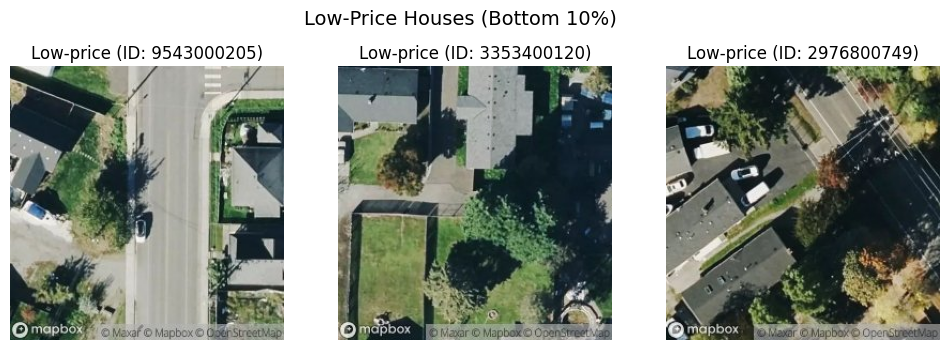

In [ ]:
plt.figure(figsize=(12,4))

for i, hid in enumerate(low_price_ids):
    img = load_image_by_id(hid)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Low-price (ID: {hid})")

plt.suptitle("Low-Price Houses (Bottom 10%)", fontsize=14)
plt.show()


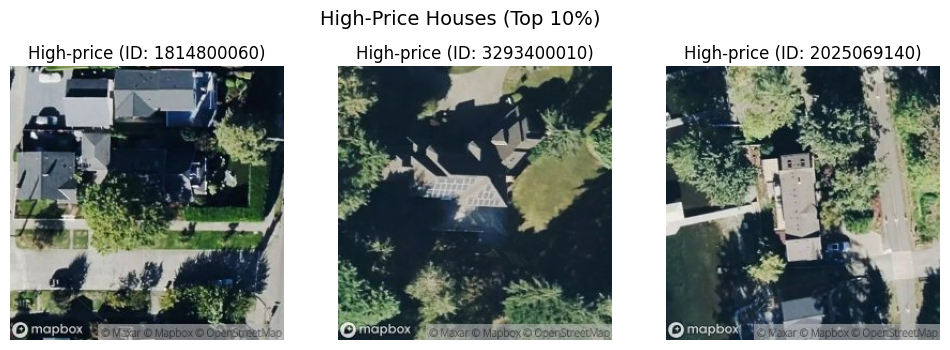

In [ ]:
plt.figure(figsize=(12,4))

for i, hid in enumerate(high_price_ids):
    img = load_image_by_id(hid)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"High-price (ID: {hid})")

plt.suptitle("High-Price Houses (Top 10%)", fontsize=14)
plt.show()


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()

        output = self.model(input_tensor)

        # Regression-safe scalar objective
        score = output.sum()
        score.backward()

        # Global average pooling on gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze()
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.detach().cpu().numpy()


In [ ]:
target_layer = resnet.layer4
gradcam = GradCAM(resnet, target_layer)

print("Grad-CAM initialized")


Grad-CAM initialized


In [ ]:
def overlay_gradcam(img, cam):
    """
    img: PIL Image
    cam: numpy array (H, W)
    """
    img_np = np.array(img)
    h, w, _ = img_np.shape

    cam_resized = cv2.resize(cam, (w, h))

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized),
        cv2.COLORMAP_JET
    )

    heatmap = heatmap.astype(np.float32) / 255
    img_float = img_np.astype(np.float32) / 255

    overlay = 0.5 * heatmap + 0.5 * img_float
    overlay = np.clip(overlay, 0, 1)

    return overlay


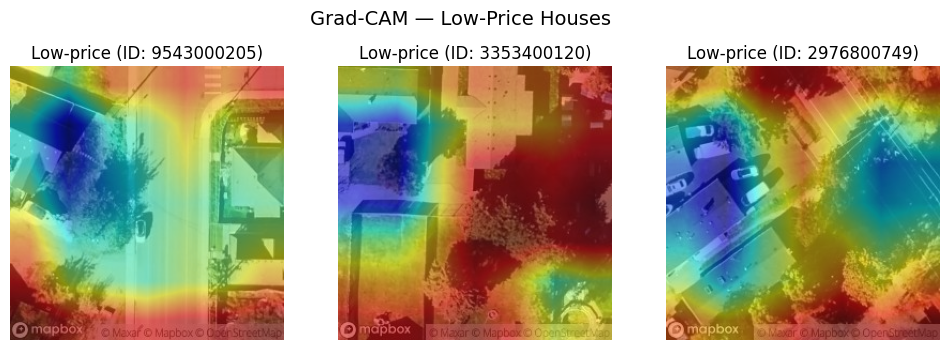

In [ ]:
plt.figure(figsize=(12,4))

for i, hid in enumerate(low_price_ids):
    img = load_image_by_id(hid)
    input_tensor = image_transforms(img).unsqueeze(0).to(device)

    cam = gradcam.generate(input_tensor)
    overlay = overlay_gradcam(img, cam)

    plt.subplot(1, 3, i+1)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Low-price (ID: {hid})")

plt.suptitle("Grad-CAM — Low-Price Houses", fontsize=14)
plt.show()


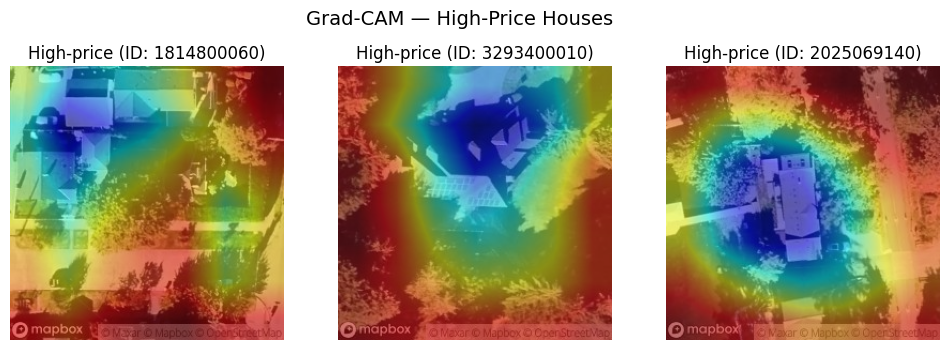

In [ ]:
plt.figure(figsize=(12,4))

for i, hid in enumerate(high_price_ids):
    img = load_image_by_id(hid)
    input_tensor = image_transforms(img).unsqueeze(0).to(device)

    cam = gradcam.generate(input_tensor)
    overlay = overlay_gradcam(img, cam)

    plt.subplot(1, 3, i+1)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"High-price (ID: {hid})")

plt.suptitle("Grad-CAM — High-Price Houses", fontsize=14)
plt.show()
